# Bayesian Logistic Regression with PyStan

TODO: Work in progress 

Authors: Jonah Gabry, Ben Goodrich, Aki Vehtari, Tuomas Sivula

The introduction to Bayesian logistic regression is from a [CRAN vignette](https://cran.r-project.org/web/packages/rstanarm/vignettes/binomial.html) by Jonah Gabry and Ben Goodrich. CRAN vignette was modified to a [R notebook](https://github.com/avehtari/BDA_R_demos/blob/master/demos_rstan/diabetes.Rmd) by Aki Vehtari.  Instead of wells data in CRAN vignette, Pima Indians data is used. The end of the notebook differs significantly from the CRAN vignette.  The R notebook was ported to this Python notebook by Aki Vehtari and Tuomas Sivula.

## Introduction

This vignette explains how to estimate generalized linear models (GLMs) for binary (Bernoulli) response variables using PyStan.

The four steps of a Bayesian analysis are

1. Specify a joint distribution for the outcome(s) and all the unknowns, which typically takes the form of a marginal prior distribution for the unknowns multiplied by a likelihood for the outcome(s) conditional on the unknowns. This joint distribution is proportional to a posterior distribution of the unknowns conditional on the observed data
2. Draw from posterior distribution using Markov Chain Monte Carlo (MCMC).
3. Evaluate how well the model fits the data and possibly revise the model.
4. Draw from the posterior predictive distribution of the outcome(s) given interesting values of the predictors in order to visualize how a manipulation of a predictor affects (a function of) the outcome(s).
This notebook demonstrates Steps 1-3 when the likelihood is the product of conditionally independent binomial distributions (possibly with only one trial per observation).

### Likelihood

For a binomial GLM the likelihood for one observation $y$ can be written as a conditionally binomial PMF $$\binom{n}{y} \pi^{y} (1 - \pi)^{n - y},$$ where $n$ is the known number of trials, $\pi = g^{-1}(\eta)$ is the probability of success and $\eta = \alpha + \mathbf{x}^\top \boldsymbol{\beta}$ is a linear predictor. For a sample of size $N$, the likelihood of the entire sample is the product of $N$ individual likelihood contributions.

Because $\pi$ is a probability, for a binomial model the link function $g$ maps between the unit interval (the support of $\pi$) and the set of all real numbers $\mathbb{R}$. When applied to a linear predictor $\eta$ with values in $\mathbb{R}$, the inverse link function $g^{-1}(\eta)$ therefore returns a valid probability between 0 and 1.

The two most common link functions used for binomial GLMs are the logit and probit functions. With the logit (or log-odds) link function $g(x) = \ln{\left(\frac{x}{1-x}\right)}$, the likelihood for a single observation becomes

$$\binom{n}{y}\left(\text{logit}^{-1}(\eta)\right)^y \left(1 - \text{logit}^{-1}(\eta)\right)^{n-y} = \binom{n}{y} \left(\frac{e^{\eta}}{1 + e^{\eta}}\right)^{y} \left(\frac{1}{1 + e^{\eta}}\right)^{n - y}$$

and the probit link function $g(x) = \Phi^{-1}(x)$ yields the likelihood

$$\binom{n}{y} \left(\Phi(\eta)\right)^{y} \left(1 - \Phi(\eta)\right)^{n - y},$$

where $\Phi$ is the CDF of the standard normal distribution. The differences between the logit and probit functions are minor and -- if, as rstanarm does by default, the probit is scaled so its slope at the origin matches the logit's -- the two link functions should yield similar results. Unless the user has a specific reason to prefer the probit link, we recommend the logit simply because it will be slightly faster and more numerically stable.

In theory, there are infinitely many possible link functions, although in practice only a few are typically used. 


### Priors

A full Bayesian analysis requires specifying prior distributions $f(\alpha)$ and $f(\boldsymbol{\beta})$ for the intercept and vector of regression coefficients. 

As an example, suppose we have $K$ predictors and believe --- prior to seeing the data --- that $\alpha, \beta_1, \dots, \beta_K$ are as likely to be positive as they are to be negative, but are highly unlikely to be far from zero. These beliefs can be represented by normal distributions with mean zero and a small scale (standard deviation).

If, on the other hand, we have less a priori confidence that the parameters will be close to zero then we could use a larger scale for the normal distribution and/or a distribution with heavier tails than the normal like the Student's $t$ distribution.

### Posterior

With independent prior distributions, the joint posterior distribution for $\alpha$ and $\boldsymbol{\beta}$ is proportional to the product of the priors and the $N$ likelihood contributions:

$$f\left(\alpha,\boldsymbol{\beta} | \mathbf{y},\mathbf{X}\right) \propto f\left(\alpha\right) \times \prod_{k=1}^K f\left(\beta_k\right) \times \prod_{i=1}^N { g^{-1}\left(\eta_i\right)^{y_i} \left(1 - g^{-1}\left(\eta_i\right)\right)^{n_i-y_i}}.$$

This is posterior distribution that PyStan will draw from when using MCMC.

## Logistic Regression Example

When the logit link function is used the model is often referred to as a logistic regression model (the inverse logit function is the CDF of the standard logistic distribution). As an example, here we will show how to carry out a analysis for Pima Indians data set similar to analysis from Chapter 5.4 of Gelman and Hill (2007) using PyStan.


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# import stan interface
import pystan

In [2]:
# add utilities directory to path
import os
util_path = '../utilities_and_data'  # provide path to utilities
util_path = os.path.abspath(util_path)
if util_path not in os.sys.path and os.path.exists(util_path):
    os.sys.path.insert(0, util_path)

# import from utilities
import stan_utility
import psis  # pareto smoothed importance sampling
import plot_tools

## Data

First we load and pre-process data.

In [3]:
# load data
path = '../utilities_and_data/diabetes.csv'
data = pd.read_csv(path)
# print some basic info()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
# preview some first rows
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# some summary
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Preprocess data

In [6]:
# modify the data column names slightly for easier typing
# rename DiabetesPedigreeFunction to dpf
data.rename(columns={'DiabetesPedigreeFunction': 'dpf'}, inplace=True)
# make lower
data.rename(columns=lambda old_name: old_name.lower(), inplace=True)

In [7]:
# removing those observation rows with 0 in selected variables
normed_predictors = [
    'glucose',
    'bloodpressure',
    'skinthickness',
    'insulin',
    'bmi'
]
data = data[(data[normed_predictors] != 0).all(axis=1)]

In [9]:
# scale the covariates for easier comparison of coefficient posteriors
# N.B. int columns turn into floats
data.iloc[:,:-1] -= data.ix[:,:-1].mean()
data.iloc[:,:-1] /= data.ix[:,:-1].std()

In [10]:
# preview some first rows againg
data.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,dpf,age,outcome
3,-0.716511,-1.089653,-0.373178,-0.584363,-0.522175,-0.709514,-1.030559,-0.967063,0
4,-1.027899,0.465719,-2.453828,0.556709,0.100502,1.424909,5.108582,0.209318,1
6,-0.093734,-1.446093,-1.653578,0.271441,-0.572662,-0.296859,-0.796108,-0.476904,1
8,-0.405123,2.409934,-0.053078,1.507603,3.255961,-0.368007,-1.056609,2.169953,1
13,-0.716511,2.150705,-0.853328,-0.584363,5.805571,-0.424924,-0.361940,2.758143,1


In [11]:
# preparing the inputs
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [12]:
# get shape into variables
n, p = X.shape
print('number of observations = {}'.format(n))
print('number of predictors = {}'.format(p))

number of observations = 392
number of predictors = 8


## Stan model code for logistic regression

Logistic regression with Student's $t$ prior as discussed above.

In [13]:
with open('logistic_t.stan') as file:
    print(file.read())

// Logistic regression with student t prior
data {
  int<lower=0> N;               // number of data points
  int<lower=1> D;               // explanatory variable dimension
  matrix[N, D] X;               // explanatory variable
  int<lower=0,upper=1> y[N];    // responce variable
  int<lower=1> p_alpha_df;      // prior degrees of freedom for alpha
  real p_alpha_loc;             // prior location for alpha
  real<lower=0> p_alpha_scale;  // prior scale for alpha
  int<lower=1> p_beta_df;       // prior degrees of freedom for beta
  real p_beta_loc;              // prior location for beta
  real<lower=0> p_beta_scale;   // prior scale for beta
}
parameters {
  real alpha;
  vector[D] beta;
}
transformed parameters {
  vector[N] eta;
  eta = alpha + X * beta;
}
model {
  alpha ~ student_t(p_alpha_df, p_alpha_loc, p_alpha_scale);
  beta ~ student_t(p_beta_df, p_beta_loc, p_beta_scale);
  y ~ bernoulli_logit(eta);
}
generated quantities {
  vector[N] log_lik;
  for (i in 1:N)
    log_li

In [14]:
model = stan_utility.compile_model('logistic_t.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_99a0b181bae8b81b7a53030709b747f3 NOW.


### Set priors and sample from the posterior

Here we'll use a Student t prior with 7 degrees of freedom and a scale of 2.5, which, as discussed above, is a reasonable default prior when coefficients should be close to zero but have some chance of being large. PyStan  returns the posterior distribution for the parameters describing the uncertainty related to unknown parameter values.

In [15]:
data = dict(
    N=n,
    D=p,
    X=X,
    y=y,
    p_alpha_df=7,
    p_alpha_loc=0,
    p_alpha_scale=2.5,
    p_beta_df=7,
    p_beta_loc=0,
    p_beta_scale=2.5
)
fit = model.sampling(data=data, seed=74749)
samples = fit.extract(permuted=True)

### Inspect the resulting posterior

Check n_effs and Rhats

In [16]:
# print summary of selected variables
# use pandas data frame for layout
summary = fit.summary(pars=['alpha', 'beta'])
pd.DataFrame(
    summary['summary'],
    index=summary['summary_rownames'],
    columns=summary['summary_colnames']
)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,-1.018092,0.002310,0.146089,-1.310326,-1.114355,-1.015954,-0.919785,-0.738640,4000.0,1.000237
beta[0],0.259150,0.003041,0.178989,-0.089089,0.137335,0.258497,0.379561,0.619517,3465.0,1.000613
beta[1],1.216258,0.002900,0.183429,0.863239,1.093088,1.213102,1.331327,1.593629,4000.0,0.999592
beta[2],-0.019320,0.002343,0.148198,-0.305982,-0.115476,-0.020974,0.076183,0.272765,4000.0,0.999835
beta[3],0.130052,0.003267,0.181186,-0.237840,0.015088,0.132539,0.254930,0.473693,3075.0,1.000645
beta[4],-0.098745,0.002482,0.156951,-0.403217,-0.202201,-0.098507,0.003856,0.212614,4000.0,0.999704
beta[5],0.503189,0.003373,0.194970,0.115131,0.375069,0.501941,0.630655,0.892501,3342.0,0.999859
beta[6],0.405977,0.002377,0.150343,0.115033,0.303252,0.402685,0.508774,0.707877,4000.0,1.000132
beta[7],0.363543,0.003201,0.190371,-0.014695,0.234509,0.359736,0.493502,0.734970,3537.0,1.000049


n_effs are high and Rhats<1.1, which is good.

Next we check divergences, E-BMFI and treedepth exceedences as explained in [Robust Statistical Workflow with PyStan Case Study](http://mc-stan.org/users/documentation/case-studies/pystan_workflow.html) by Michael Betancourt.

In [21]:
stan_utility.check_treedepth(fit)
stan_utility.check_energy(fit)
stan_utility.check_div(fit)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 4000 iterations ended with a divergence (0.0%)


Everything is fine based on these diagnostics and we can proceed with our analysis.

Visualise the marginal posterior distributions of each parameter

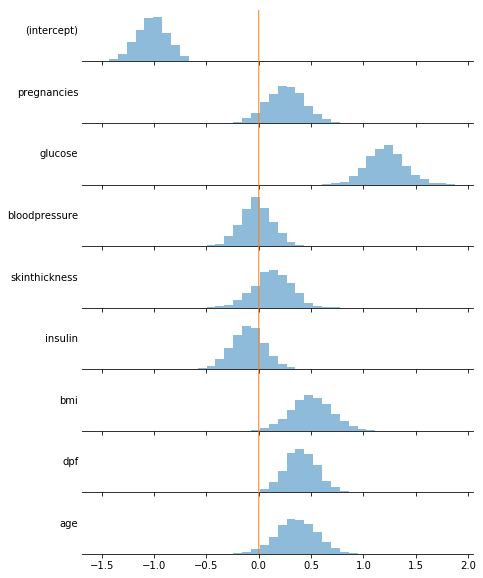

In [22]:
# use same explicit bin edges for all the plots
n_bins = 40  # number of bins in the whole range

# get range of all samples
xrange = [
    min(np.min(samples['alpha']), np.min(samples['beta'])),
    max(np.max(samples['alpha']), np.max(samples['beta'])),
]

# set up multiple plots
fig, axes = plt.subplots(
    nrows=p+1, ncols=1, sharex=True, sharey=True, figsize=(7, 10))
# plot intercept
ax = axes[0]
ax.hist(
    samples['alpha'],
    bins=np.linspace(*xrange, n_bins+1),
    color=plot_tools.lighten('C0')
)
ax.set_ylabel('(intercept)', rotation='horizontal', ha='right')
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(())
# plot slopes
for i, ax  in enumerate(axes[1:]):
    ax.hist(
        samples['beta'][:, i],
        bins=np.linspace(*xrange, n_bins+1),
        color=plot_tools.lighten('C0')
    )
    ax.set_ylabel(
        X.columns[i],
        rotation='horizontal',
        ha='right'
    )
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks(())

# draw x=0 line accross all the figures
xzero = mpl.patches.ConnectionPatch(
    xyA=(0, 0),
    xyB=(0, axes[0].get_ylim()[1]),
    coordsA="data",
    coordsB="data",
    axesA=axes[-1],
    axesB=axes[0],
    color='C1'
)
axes[-1].add_artist(xzero);

We can use Pareto smoothed importance sampling leave-one-out cross-validation to estimate the predictive performance.

In [23]:
loo, loos, ks = psis.psisloo(samples['log_lik'])

In [24]:
print('elpd_loo: {:.4}'.format(loo))

elpd_loo: -182.3


In [25]:
# check the number of large (> 0.5) Pareto k estimates
np.sum(ks > 0.5)

0